In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, TimeDistributed, Dropout
from keras import optimizers
from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tf.random.set_seed(42)

file_name = '/content/drive/My Drive/Colab Notebooks/extrusion.csv'

df = pd.read_csv(file_name)
df.info()

columns = df.columns.tolist()
print(columns)


print(df.shape)
print(np.shape(columns))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226536 entries, 0 to 226535
Columns: 470 entries, Datum to ST114_VARWdTensVis
dtypes: float64(469), object(1)
memory usage: 812.3+ MB
['Datum', 'ST0_VARActAuftrag', 'ST110_VARExtr_0_HeizungZone_3_Regler_Y', 'ST110_VARExtr_0_HeizungZone_3_SollTemp', 'ST110_VARExtr_0_HeizungZone_4_Konfig', 'ST110_VARExtr_0_HeizungZone_4_Regler_X', 'ST110_VARExtr_0_HeizungZone_4_Regler_Y', 'ST110_VARExtr_0_HeizungZone_4_SollTemp', 'ST110_VARExtr_0_HeizungZone_5_Konfig', 'ST110_VARExtr_0_HeizungZone_5_Regler_X', 'ST110_VARExtr_0_HeizungZone_5_Regler_Y', 'ST110_VARExtr_0_HeizungZone_5_SollTemp', 'ST110_VARExtr_0_HeizungZone_6_Konfig', 'ST110_VARExtr_0_HeizungZone_6_Regler_X', 'ST110_VARExtr_0_HeizungZone_6_Regler_Y', 'ST110_VARExtr_0_HeizungZone_6_SollTemp', 'ST110_VARExtr_0_HeizungZone_7_Konfig', 'ST110_VARExtr_0_HeizungZone_7_Regler_X', 'ST110_VARExtr_0_HeizungZone_7_Regler_Y', 'ST110_VARExtr_0_HeizungZone_7_SollTemp', 'ST110_VARExtr_0_HeizungZone_8_Konfig

In [ ]:
del df['Datum']
columns.remove('Datum')

In [ ]:
target_index = columns.index('ST110_VAREx_0_SDickeIst')
print(target_index)

157


In [ ]:
X = np.asarray(df)[:, :]
Y = np.asarray(df)[:, target_index]

print("X.shape: ", X.shape)
print("Y.shape: ", Y.shape)

X.shape:  (226536, 469)
Y.shape:  (226536,)


In [ ]:
selected_feature_idx = [36, 46, 130, 156, 157, 159, 253, 261, 274, 278, 288, 465, 468]

In [ ]:
x = min_max_scaling(X0[:, selected_feature_idx])
y = min_max_scaling(Y0)
print(x.shape)
print(y.shape)

(18397, 13)
(18397,)


In [ ]:
predict_length = 1

dataX = []
dataY = []
for i in range(0, len(y) - seq_length - predict_length + 1):
    _x = x[i : i + seq_length]
    _y = y[i + seq_length : i + seq_length + predict_length]
    dataX.append(_x)
    dataY.append(_y)

dataX = np.array(dataX)
dataY = np.array(dataY)

print(dataX.shape)
print(dataY.shape)

(17397, 1000, 13)
(17397, 1)


In [ ]:
trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=0.3, shuffle = False)
trainY = tf.expand_dims(trainY,2)
testY = tf.expand_dims(testY,2)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(12177, 1000, 13)
(12177, 1, 1)
(5220, 1000, 13)
(5220, 1, 1)


In [ ]:
# LSTM 모델 / LSTM Model
model = Sequential([
    LSTM(32, input_shape = (seq_length, len(selected_feature_idx)), return_sequences=True, activation = 'relu'),
    LSTM(64, return_sequences=True, activation = 'relu'),
    Dropout(0.5),
    LSTM(64, return_sequences=False, activation = 'relu',kernel_initializer='he_uniform'),
    Dense(64, activation = 'relu'),
    # LSTM(8, return_sequences=False, activation = 'sigmoid'),
    Dense(predict_length)
])

model.summary()

#kernel_initializer='he_uniform'

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 1000, 32)          5888      
_________________________________________________________________
lstm_9 (LSTM)                (None, 1000, 64)          24832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000, 64)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 67,969
Trainable params: 67,969
Non-trainable params: 0
__________________________________________________

In [ ]:
    # LSTM(32, input_shape = (seq_length, len(selected_feature_idx)), return_sequences=True, activation = 'relu'),
    # LSTM(32, return_sequences=False, activation = 'relu'),
    # Dropout(0.3),
    # Dense(64, activation = 'relu'),

#     model = Sequential([
#     LSTM(32, input_shape = (seq_length, len(selected_feature_idx)), return_sequences=True, activation = 'relu'),
#     LSTM(64, return_sequences=True, activation = 'relu'),
#     Dropout(0.3),
#     LSTM(64, return_sequences=False, activation = 'relu'),
#     Dense(64, activation = 'relu'),
#     # LSTM(8, return_sequences=False, activation = 'sigmoid'),
#     Dense(predict_length)
# ])

# model.summary()

In [ ]:
# 모델 학습 설정 및 진행 / Model Training options and Progress
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='loss', patience=5)

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mse', optimizer = adam, metrics=["mse"])
history = model.fit(trainX, trainY, batch_size = 100, epochs = 5, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/10
110/110 [==============================] - 240s 2s/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 2/10
110/110 [==============================] - 244s 2s/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 3/10
110/110 [==============================] - 243s 2s/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 4/10
110/110 [==============================] - 243s 2s/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 5/10
110/110 [==============================] - 243s 2s/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 6/10
110/110 [==============================] - 244s 2s/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 7/10
110/110 [==============================] - 244s 2s/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 8/10
110/110 [==============================] - 246s 2s/step - 

No handles with labels found to put in legend.


[0.003400081302970648, 0.001752649899572134, 0.00164689589291811, 0.00141313043422997, 0.0011608811328187585, 0.0011107356986030936, 0.0008770883432589471, 0.0008442584075964987, 0.0007148339063860476, 0.0006310174358077347]


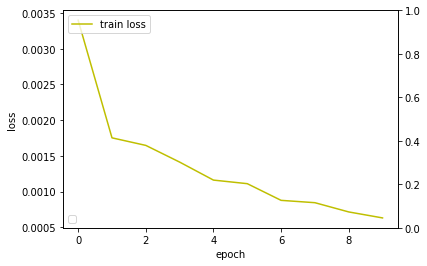

In [ ]:
# 학습 과정 살펴보기 / watching train loss
print(history.history['loss'])
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()

In [ ]:
model.evaluate(testX, testY)

164/164 [==============================] - 42s 253ms/step - loss: 0.0027 - mse: 0.0027


[0.0026854793541133404, 0.0026854793541133404]

In [ ]:
# 예측
pred = model.predict(testX)

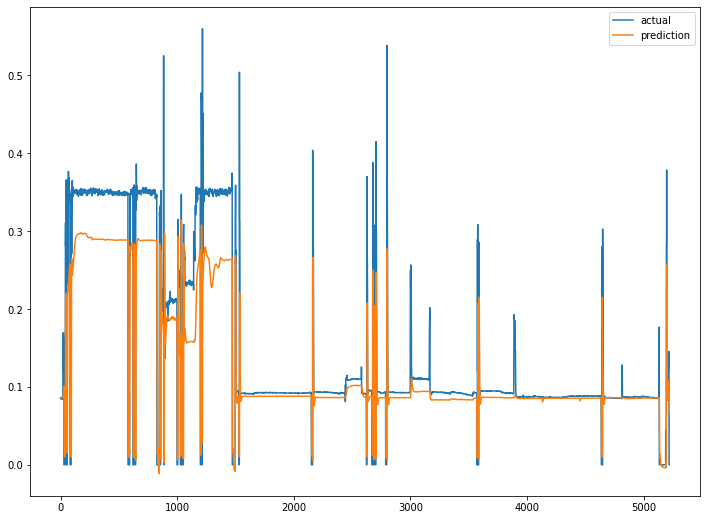

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(testY[:,0], label='actual')
plt.plot(pred[:,0], label='prediction')
plt.legend()
# plt.xlim(0,2000)
# plt.ylim(-0.2, 1.2)
plt.show()